In [7]:
fuel_cols = df.columns.str.contains('consumption', case=False)

In [12]:
df.loc[:,fuel_cols].corr()

,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG
FUELCONSUMPTION_CITY,1.000000,0.965718,0.995542,-0.935613
FUELCONSUMPTION_HWY,0.965718,1.000000,0.985804,-0.893809
FUELCONSUMPTION_COMB,0.995542,0.985804,1.000000,-0.927965
FUELCONSUMPTION_COMB_MPG,-0.935613,-0.893809,-0.927965,1.000000


In [13]:
# 1. CLEAN
# Drop EVERYTHING redundant.
# We keep 'FUELCONSUMPTION_COMB' (L/100km) as our single source of truth for fuel.
features_final = df.drop(['MODELYEAR', 'MAKE', 'MODEL', 
                          'FUELCONSUMPTION_COMB_MPG', 
                          'FUELCONSUMPTION_CITY', 
                          'FUELCONSUMPTION_HWY', 
                          'CO2EMISSIONS'], axis=1)

# 2. ENCODE (One-Hot)
# Turn Text categories into Numbers
features_final_encoded = pd.get_dummies(features_final, 
                                        columns=['VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE'], 
                                        drop_first=True)

# 3. SPLIT
X_train, X_test, y_train, y_test = train_test_split(features_final_encoded, target, test_size=0.2, random_state=42)

# 4. SCALE
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train)
X_test_final = scaler.transform(X_test)

# 5. TRAIN
model_final = LinearRegression()
model_final.fit(X_train_final, y_train)

# 6. EVALUATE
y_pred_final = model_final.predict(X_test_final)

print(f"Final 'Golden' R2 Score: {r2_score(y_test, y_pred_final):.4f}")
print(f"Number of Features used: {features_final_encoded.shape[1]}")

Final 'Golden' R2 Score: 0.9893
Number of Features used: 42


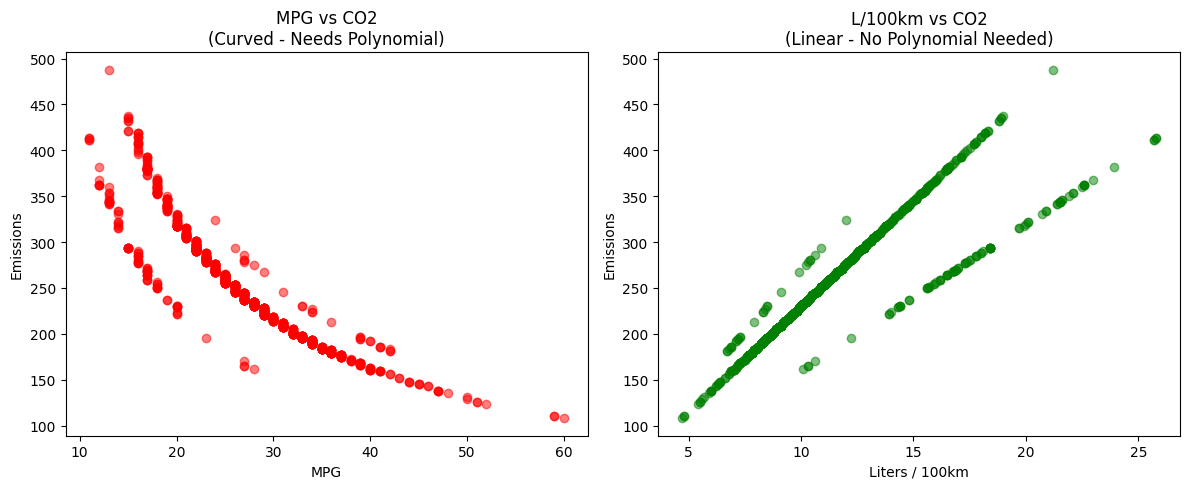

In [15]:
plt.figure(figsize=(12, 5))

# Plot 1: MPG vs CO2 (The Curve)
plt.subplot(1, 2, 1)
plt.scatter(df['FUELCONSUMPTION_COMB_MPG'], df['CO2EMISSIONS'], alpha=0.5, color='red')
plt.title("MPG vs CO2\n(Curved - Needs Polynomial)")
plt.xlabel("MPG")
plt.ylabel("Emissions")

# Plot 2: L/100km vs CO2 (The Line)
plt.subplot(1, 2, 2)
plt.scatter(df['FUELCONSUMPTION_COMB'], df['CO2EMISSIONS'], alpha=0.5, color='green')
plt.title("L/100km vs CO2\n(Linear - No Polynomial Needed)")
plt.xlabel("Liters / 100km")
plt.ylabel("Emissions")

plt.tight_layout()
plt.show()

In [16]:
from sklearn.ensemble import RandomForestRegressor

# 1. Initialize the Regressor
# n_estimators=100 means "Build 100 trees"
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train (Fit)
rf_model.fit(X_train_final, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test_final)

# 4. Evaluate
print(f"Linear Regression R2: {r2_score(y_test, y_pred_final):.4f}") # Your previous best
print(f"Random Forest R2:     {r2_score(y_test, y_pred_rf):.4f}")     # The Challenger

Linear Regression R2: 0.9893
Random Forest R2:     0.9939


In [17]:
from xgboost import XGBRegressor

# 1. Initialize
# n_estimators=100: Create 100 sequential correction trees
# learning_rate=0.1: How drastically we correct mistakes (Lower is usually more precise but slower)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 2. Train
xgb_model.fit(X_train_final, y_train)

# 3. Predict
y_pred_xgb = xgb_model.predict(X_test_final)

# 4. Compare All Three
print(f"Linear Regression R2: {r2_score(y_test, y_pred_final):.4f}")
print(f"Random Forest R2:     {r2_score(y_test, y_pred_rf):.4f}")
print(f"XGBoost R2:           {r2_score(y_test, y_pred_xgb):.4f}")

Linear Regression R2: 0.9893
Random Forest R2:     0.9939
XGBoost R2:           0.9965


<Figure size 1000x800 with 0 Axes>

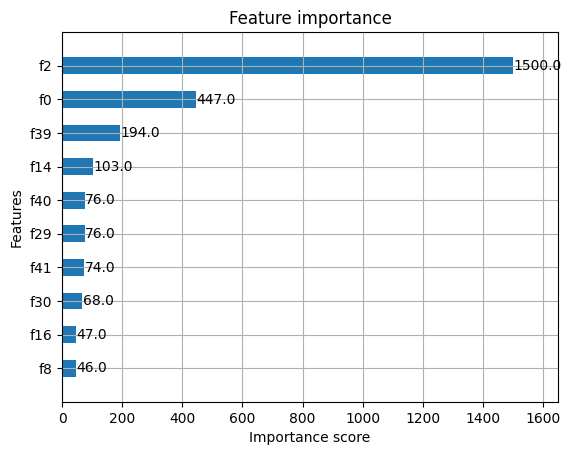

In [21]:
from xgboost import plot_importance

# Plot the Feature Importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, height=0.5, max_num_features=10) # Top 10 features
plt.show()

In [20]:
# Get the feature names from your encoded dataframe
feature_names = features_final_encoded.columns

# Map the "f0, f1..." to real names
# We create a dictionary to see exactly who is who
mapper = {f'f{i}': name for i, name in enumerate(feature_names)}

print("--- TOP 3 FEATURES ---")
print(f"f2 (Winner): {mapper['f2']}")
print(f"f0 (2nd):    {mapper['f0']}")
print(f"f1 (3rd):    {mapper['f1']}")

--- TOP 3 FEATURES ---
f2 (Winner): FUELCONSUMPTION_COMB
f0 (2nd):    ENGINESIZE
f1 (3rd):    CYLINDERS


In [22]:
# 1. Select the "Curved" Feature (MPG) + The Categorical stuff
# We are deliberately using the 'Hard' column (MPG) instead of the 'Easy' one (COMB)
features_curved = df.drop(['MODELYEAR', 'MAKE', 'MODEL', 
                           'FUELCONSUMPTION_COMB',      # Drop the Linear helper
                           'FUELCONSUMPTION_CITY', 
                           'FUELCONSUMPTION_HWY', 
                           'CO2EMISSIONS'], axis=1)

# 2. Encode
features_curved_encoded = pd.get_dummies(features_curved, columns=['VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE'], drop_first=True)

# 3. Split & Scale
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features_curved_encoded, target, test_size=0.2, random_state=42)
# (Note: Scaling isn't strictly necessary for Trees, but it doesn't hurt)
scaler = StandardScaler()
X_train_c = scaler.fit_transform(X_train_c)
X_test_c = scaler.transform(X_test_c)

# 4. Train XGBoost on Raw Curved Data
xgb_curved = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_curved.fit(X_train_c, y_train_c)

# 5. Evaluate
print(f"XGBoost on Curved MPG (No Polynomials): {r2_score(y_test_c, xgb_curved.predict(X_test_c)):.4f}")

XGBoost on Curved MPG (No Polynomials): 0.9942
